In [1]:
import networkx as nx
seed=1000           # seed the graph for reproducibility, you should be doing this  
G= nx.gnp_random_graph (100, .02, seed=seed )       # here we create a random binomial graph with 10 nodes and an average (expected) connectivity of 10*.3= 3.
print ( G.nodes() )

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [2]:
print(G.edges())

[(0, 35), (0, 54), (1, 25), (1, 44), (3, 90), (4, 47), (4, 56), (4, 82), (5, 50), (5, 80), (6, 30), (6, 68), (6, 69), (6, 75), (7, 13), (7, 29), (7, 38), (8, 47), (8, 56), (9, 65), (9, 92), (11, 56), (12, 29), (12, 45), (14, 55), (14, 64), (14, 65), (15, 97), (16, 44), (16, 73), (17, 45), (18, 85), (19, 55), (20, 24), (20, 71), (23, 53), (23, 90), (24, 39), (24, 47), (24, 80), (24, 93), (25, 26), (25, 39), (25, 74), (26, 35), (26, 39), (26, 45), (26, 61), (27, 56), (28, 34), (28, 53), (28, 54), (29, 30), (29, 48), (29, 60), (29, 71), (30, 61), (32, 46), (32, 67), (34, 47), (34, 51), (34, 80), (34, 81), (34, 92), (35, 78), (35, 85), (36, 45), (37, 43), (37, 78), (37, 86), (38, 59), (38, 63), (39, 42), (39, 48), (40, 96), (42, 57), (42, 66), (42, 75), (43, 56), (43, 58), (43, 98), (44, 55), (44, 87), (47, 59), (47, 76), (47, 79), (47, 85), (47, 98), (47, 99), (48, 83), (51, 99), (52, 72), (52, 81), (54, 59), (54, 74), (55, 72), (56, 93), (57, 94), (57, 99), (60, 76), (63, 90), (66, 83), 

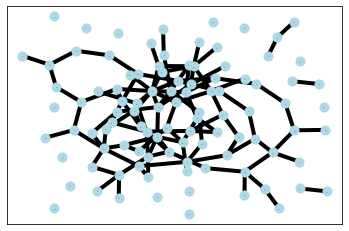

In [4]:
import matplotlib.pyplot as plt

links = [(u, v) for (u, v, d) in G.edges(data=True)]
pos = nx.nx_pydot.graphviz_layout(G) 

nx.draw_networkx_nodes(G, pos, node_size=100, node_color='lightblue', linewidths=0.07) # draw nodes
nx.draw_networkx_edges(G, pos, edgelist=links, width=4)                                 # draw edges

# node labels
nx.draw_networkx_labels(G, pos, font_size=1, font_family="sans-serif")
# edge weight labels

edge_labels = nx.get_edge_attributes(G, "weight")

nx.draw_networkx_edge_labels(G, pos, edge_labels)

plt.show()

# van description
- id: unique id for the car
- path: queue that includes all nodes that are going to be visited
- S: schedule queue. It is a queue of tuples. Tuple has 3 items where:
    * `tuple[0]` passenger name
    * `tuple[1]` location point
    * `tuple[2]` status `0 = pickup` `1 = dropoff`

In [3]:
vans = [
    {'id':1,
    'path':[1,2,3,5,6],
     'S':[('p1',3,0)]
    }
]

print(vans[0]['path'])
print(vans[0]['path'])
vans[0]['path'].pop(0)
print(vans[0]['path'])

[1, 2, 3, 5, 6]
[1, 2, 3, 5, 6]
[2, 3, 5, 6]


In [5]:
#updates path for next points
def updatePath(van,newNodes):
    return van['path']+newNodes[1:]

def updateS(van):
    pass

def generateOrders():
    Q=[]
    #generate node
    #check if node connected and drivers can get there
    #if yes add to queue
    #else: pass

    return Q

#testing
van = updatePath(vans[0],[6,7,8,10])
print(van)


[2, 3, 5, 6, 7, 8, 10]
